Добрый день,
 
В Папку Лекции выложил лекции по начальной выставке БИНС.
 
Каждому из вас даю одинаковое задание:

    Даю каждому свой файл данных с колонками: время, показаний 3-х акселерометров и трех датчиков угловой скорости (ДУС). Размерности указаны.
    Ориентация осей либо продольная ось (X), вертикальная ось (Y), правое крыло (Z), либо правое крыло (s1), продольная ось (s2), вертикальная (s3. Это легко уточняется по колонке, где показание акселерометра равно примерно 9.81….
    Требуется определить три угла: тангаж, крен, курс (в градусах), географическую широту места (градус).
     Требуется построить графики накапливающихся средних значений показаний акселерометров, ДУС, а также соответствующих среднеквадратичных отклонений.
     

dt следует брать из разности показаний
следует внимательно посмотреть на оси
и внимательно на интервалы вибрационного и прочего воздействия на объект выставки

In [1]:
%matplotlib inline
import math
from math import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy import stats

In [15]:
R_earth = 6371000
a = 6378137.0
aa = 6378137.0
b = 6356752.0
e2 = 6.6943799901413 * (10 ** -3)
delta_t = d_t = dt = 0.0025
phi = phi_init = phi_0 = 31.2*pi/180.0          #initial latitude in radians - FALSE
lambda_init = lambda_0 = 121.3*pi/180.0      #initial longitude in radians - FALSE
h = h_init = h_0 = 100                        #initial altitude in meters - TRUE
u = 2 * pi / 86164.090530833
global R_E 
R_E = a / ((1 - e2 * (sin(phi) ** 2)) ** 0.5)
global R_N
R_N = a * (1 - e2) / ((1 - e2 * (sin(phi) ** 2)) ** 1.5)
con = (u**2)*((R_E+h) * math.sin(phi) * math.cos(phi))
#chi = 1.68502813 #азимутальный угол, радианы

In [8]:
def CNFparser(filename):
    '''
    Тут мы расписываем парсер
    CNFnav - кусок для работы в режиме навигации
    CNFalign - кусок для выставки (причём секунд 10-20 из него для алгебраической, остальное на кинематику)
    '''
    CNFnames = ['Time','AccX','AccY','AccZ','OmX','OmY','OmZ','H']
    CNF = pd.read_csv(filename, sep = '\s+' ,header = None, names = CNFnames, skiprows = 1)
    #CNFalign = CNF[CNF.FlagAlignment == 1]
    #CNFalign = CNFalign.loc[:,['Time','OmX','OmY','OmZ','AccX','AccY','AccZ']]
    #CNFnav = CNF[CNF.FlagAlignment == 0]
    #CNFnav = CNFnav.loc[:,['Time','OmX','OmY','OmZ','AccX','AccY','AccZ']]
    #CNF = []
    CNF['Invariant'] = CNF.AccX*CNF.OmX +  CNF.AccY*CNF.OmY +  CNF.AccZ*CNF.OmZ
    #CNF['g\''] = (CNF.AccX**2 + CNF.AccY**2 + CNF.AccZ**2)**(0.5)
    CNF['W_Std500'] = (CNF.Invariant.rolling(window = 500, center = False).std()).dropna()
    return CNF

In [9]:
CNF = CNFparser('./INS_3_2.txt')

In [13]:
CNF.Time[0]-CNF.Time[1]

-0.0025000000000545697

In [11]:
CNF.describe()

,Time,AccX,AccY,AccZ,OmX,OmY,OmZ,H,Invariant,W_Std500
count,676251.000000,676251.000000,676251.000000,676251.000000,676251.000000,676251.000000,676251.000000,676251.0,676251.000000,675752.000000
mean,2754.674061,0.180927,-0.108482,9.812357,-0.000038,-0.000013,0.000061,100.0,0.000579,0.004880
std,488.050287,0.004446,0.071474,0.055071,0.012124,0.000415,0.000440,0.0,0.004907,0.000557
min,1909.348041,0.156578,-0.279866,9.676982,-0.025576,-0.001963,-0.002049,100.0,-0.023161,0.003813
25%,2332.011051,0.177940,-0.175552,9.760486,-0.011611,-0.000279,-0.000213,100.0,-0.002650,0.004476
50%,2754.674060,0.180932,-0.108247,9.812340,-0.000046,-0.000010,0.000056,100.0,0.000570,0.004652
75%,3177.337070,0.183913,-0.041506,9.864075,0.011541,0.000252,0.000338,100.0,0.003792,0.005427
max,3600.000080,0.208240,0.067274,9.949390,0.025093,0.001930,0.002131,100.0,0.023477,0.006515


In [10]:
CNF

,Time,AccX,AccY,AccZ,OmX,OmY,OmZ,H,Invariant,W_Std500
0,1909.348041,0.179717,-0.173474,9.867469,0.015186,0.000801,-0.000367,100.0,-0.001030,NaN
1,1909.350541,0.184395,-0.116951,9.804570,-0.011850,0.000058,0.000412,100.0,0.001843,NaN
2,1909.353041,0.177705,-0.036077,9.760693,-0.002734,-0.000388,0.000496,100.0,0.004373,NaN
3,1909.355541,0.175688,-0.181746,9.877270,0.013422,0.000420,-0.000457,100.0,-0.002237,NaN
4,1909.358042,0.185866,-0.095217,9.799156,-0.012572,0.000293,0.000404,100.0,0.001595,NaN
5,1909.360542,0.188293,-0.044645,9.767680,-0.000916,-0.000097,-0.000578,100.0,-0.005813,NaN
6,1909.363042,0.172833,-0.204624,9.876915,0.014042,0.000335,0.000438,100.0,0.006681,NaN
7,1909.365542,0.175460,-0.081272,9.787695,-0.014638,0.000152,0.000206,100.0,-0.000566,NaN
8,1909.368042,0.185467,-0.043622,9.774943,0.002733,0.000394,-0.000186,100.0,-0.001326,NaN
9,1909.370542,0.179064,-0.208546,9.884666,0.011459,-0.000321,-0.000010,100.0,0.002023,NaN


In [17]:
def g_phi(phi, h, a, e2):
    #g1 = 9.78030 * (1 - 2 * h / a + 3 * e2 * sin(phi) ** 2 / 4)
    g = 9.78030*(1+0.005302*sin(phi)*sin(phi)-0.000007*sin(2*phi)*sin(2*phi))
    return g#(f_x**2 + f_y**2 + f_z**2)**(0.5) #

In [18]:
g_phi(phi_0, h_0, a, e2)
global g
g = g_phi(phi_0, h_0, a, e2)
print(g)
temp = np.mean(CNF.loc[:,['AccX','AccY','AccZ','OmX','OmY','OmZ']].values, axis = 0).reshape(6,1)
print ('g\' = ', np.linalg.norm(temp[0:3]))
print ('\delta g = ', np.linalg.norm(temp[0:3]) - g_phi(phi_0, h_0, a, e2))
#del temp

9.79416166528857
g' =  9.814624541745097
\delta g =  0.020462876456527113


In [ ]:
u*cos(phi)

In [ ]:
u*sin(phi)

In [6]:
CNF.describe()

,Time,AccX,AccY,AccZ,OmX,OmY,OmZ,Invariant,W_Std500
count,676251.000000,676251.000000,676251.000000,676251.000000,676251.000000,676251.000000,676251.0,676251.000000,675752.000000
mean,0.180927,-0.108482,9.812357,-0.000038,-0.000013,0.000061,100.0,-0.003198,1.213445
std,0.004446,0.071474,0.055071,0.012124,0.000415,0.000440,0.0,1.212565,0.028050
min,0.156578,-0.279866,9.676982,-0.025576,-0.001963,-0.002049,100.0,-2.554327,1.132493
25%,0.177940,-0.175552,9.760486,-0.011611,-0.000279,-0.000213,100.0,-1.160515,1.194156
50%,0.180932,-0.108247,9.812340,-0.000046,-0.000010,0.000056,100.0,-0.003811,1.210279
75%,0.183913,-0.041506,9.864075,0.011541,0.000252,0.000338,100.0,1.154657,1.229127
max,0.208240,0.067274,9.949390,0.025093,0.001930,0.002131,100.0,2.514225,1.420204


In [ ]:
CNFinit = CNF.loc[:1999,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values

In [19]:
stats.describe(CNF)

DescribeResult(nobs=676251, minmax=(array([ 1.90934804e+03,  1.56577800e-01, -2.79865900e-01,  9.67698190e+00,
       -2.55762800e-02, -1.96283000e-03, -2.04910000e-03,  1.00000000e+02,
       -2.31607302e-02,             nan]), array([3.60000008e+03, 2.08240400e-01, 6.72744000e-02, 9.94939040e+00,
       2.50931400e-02, 1.93040000e-03, 2.13127000e-03, 1.00000000e+02,
       2.34770326e-02,            nan])), mean=array([ 2.75467406e+03,  1.80927402e-01, -1.08481945e-01,  9.81235710e+00,
       -3.80032056e-05, -1.26768643e-05,  6.09481060e-05,  1.00000000e+02,
        5.79143907e-04,             nan]), variance=array([2.38193083e+05, 1.97685116e-05, 5.10847592e-03, 3.03281218e-03,
       1.46997014e-04, 1.72503043e-07, 1.93733543e-07, 0.00000000e+00,
       2.40746584e-05,            nan]), skewness=array([ 2.30041566e-10, -3.84338076e-03,  2.93182308e-03,  3.35367735e-03,
       -1.23134774e-04,  2.56991260e-03,  5.62403147e-04,  0.00000000e+00,
        9.47613299e-03,             na

In [20]:
def initial_calibration_naive(A, phi, h, a, e2, u):
    L = np.zeros((3, 3))
    means = np.mean(A[:, 1:], axis = 0).reshape(6,1)
    theta = math.atan2(means[0], math.sqrt(means[1]**2+means[2]**2))
    gamm = -math.atan2(means[2], means[1])
    L[:, 2:3] = means[0:3] / 9.812357#(g_phi(phi, h, a, e2))
    L[:, 1:2] = (means[3:6] - (L[:, 2:3] * u * sin(phi))) / (u * cos(phi))
    L[:, 0:1] = np.cross(L[:, 1:2].T, L[:, 2:3].T).T
    L[:, 2:3] /= np.linalg.norm(L[:, 2:3], 2)
    L[:, 1:2] /= np.linalg.norm(L[:, 1:2], 2)
    L[:, 0:1] /= np.linalg.norm(L[:, 0:1], 2)
    psi = math.atan2(L[0][0], L[0][1])
    return L, theta, gamm, psi, means

In [24]:
def initial_algebraic_alignment():
    '''
    Это функция начальной алгебраической выставки - в глобальные переменные записываются значения углов, которые 
    позднее буду использовать как начальные приближения для алгоритмов точной выставки
    '''
    global g
    global L, L_al
    global theta, gamm, phi, psi, chi, chi_al, psi_al, theta_al, gamm_al, L_al, om
    DELIMITER0 = 0 
    DELIMITER = (15*int((1/dt)))  # 15 секунд
    om_x = CNF['OmX'][:].mean()
    om_y = CNF['OmY'][:].mean()  
    om_z = CNF['OmZ'][:].mean()
    f_x = CNF['AccX'][:].mean()
    f_y = CNF['AccY'][:].mean()
    f_z = CNF['AccZ'][:].mean()
    theta = math.atan2(f_x, math.sqrt(f_y*f_y+f_z*f_z))
    gamm = -math.atan2(f_z, f_y)
    om = math.sqrt(om_x**2+om_y**2+om_z**2)
    
    phi = math.atan2(om_z, math.sqrt(om_x**2+om_y**2))
    g_mean = math.sqrt(f_x**2+f_y**2+f_z**2)
    print ('phi_rude = ',phi*180/pi)
    print ('g_phi = ', g_phi(phi, h, a, e2))
    print('g_mean - g_phi = ',-g_phi(phi, h, a, e2) + f_z)
    
    l13 = sin(theta)
    l23 = cos(theta)*cos(gamm)
    l33 = -cos(theta)*sin(gamm)
    l12 = (om_x - u*l13*sin(phi))/(u*cos(phi))
    l22 = (om_y - u*l23*sin(phi))/(u*cos(phi))
    l32 = (om_z - u*l33*sin(phi))/(u*cos(phi))
    l12 = l12/(sqrt(l12*l12+l22*l22+l32*l32)) #нормировка
    l22 = l22/(sqrt(l12*l12+l22*l22+l32*l32))
    l32 = l32/(sqrt(l12*l12+l22*l22+l32*l32))
    #теперь нужно векторно умножить второй на третий
    l11 = l22*l33 - l32*l23
    l21 =-l12*l33 + l13*l32
    l31 = l12*l23 - l22*l13
    L = np.matrix([[l11, l12, l13], [l21, l22, l23], [l31, l32, l33]])   #записали в матрицу
    psi = math.atan2(L.item(0,0),L.item(0,1))
    theta = math.asin(L.item(0,2))
    gamm = -math.atan2(L.item(2,2),L.item(1,2))
    chi = (psi*180./math.pi - 90.)*math.pi/180 #угол азимутальной ориентации
    chi_al = chi
    psi_al = psi                                      
    theta_al = theta
    gamm_al = gamm
    L_al = L

In [25]:
initial_algebraic_alignment()
print(L, np.linalg.det(L), om, om-0.000072921158553)
#thhh = atan2(L[0][2], (L[0][0]**2+L[0][1]**2)**(0.5))
#gmmm = atan2(-L_0[2][2],L_0[1][2])
#pssss = atan2(L_0[0][0], L_0[0][1])
print(theta*180/pi, theta)
print(gamm*180/pi, gamm)
print(psi*180/pi, psi)

phi_rude =  56.68269169910939
g_phi =  9.816452584905193
g_mean - g_phi =  -0.0040954859146413725
[[-2.99037932e-01 -9.56022967e-01  1.84344701e-02]
 [ 9.55814156e-01 -2.99114264e-01 -1.10530917e-02]
 [ 1.60810225e-02  6.53984440e-04  9.99768973e-01]] 1.003262984716304 7.293571246532863e-05 1.4553912328633045e-08
1.0562771630061651 0.018435514308082424
-90.63341604243499 -1.5818515222703393
-162.6306475922038 -2.8384402651345444


In [26]:
def L_create(theta, gamm, psi):
    L = np.array([[sin(psi)*cos(theta)                      , cos(psi)*cos(theta)                                , sin(theta)],
         [cos(psi)*sin(gamm)-sin(psi)*sin(theta)*cos(gamm), -sin(psi)*sin(gamm)-cos(psi)*sin(theta)*cos(gamm), cos(theta)*cos(gamm)],
         [cos(psi)*cos(gamm)+sin(psi)*sin(theta)*sin(gamm), -sin(psi)*cos(gamm)+cos(psi)*sin(theta)*sin(gamm), -cos(theta)*sin(gamm)]])
    return L.reshape((3,3))

In [27]:
print(theta, gamm, psi)

0.018435514308082424 -1.5818515222703393 -2.8384402651345444


In [28]:
print(L, np.linalg.det(L))
print(L_al, np.linalg.det(L_al))

[[-2.99037932e-01 -9.56022967e-01  1.84344701e-02]
 [ 9.55814156e-01 -2.99114264e-01 -1.10530917e-02]
 [ 1.60810225e-02  6.53984440e-04  9.99768973e-01]] 1.003262984716304
[[-2.99037932e-01 -9.56022967e-01  1.84344701e-02]
 [ 9.55814156e-01 -2.99114264e-01 -1.10530917e-02]
 [ 1.60810225e-02  6.53984440e-04  9.99768973e-01]] 1.003262984716304


# Графики накапливающихся средних значений акселерометров, ДУС, а также соответствующие среднеквадратические отклонения

In [31]:
CNF_det = CNF.loc[:,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values

In [32]:
det = np.zeros((0, 14))
mu = CNF.loc[0,['AccX','AccY','AccZ','OmX','OmY','OmZ', 'Invariant']].values
#time = CNF.loc[0,['Time']].values
sigma = mu*0
print(mu)
print(sigma)
det = np.append(det, np.append(mu, sigma).reshape((1,14)), axis = 0)

print(det)
x_prev = CNF.loc[0,['AccX','AccY','AccZ','OmX','OmY','OmZ', 'Invariant']].values
i = 0
#coordinates = np.append([phi_0, lambda_0, h_0], V_0.T)
for x in CNF.loc[1:23900,['AccX','AccY','AccZ','OmX','OmY','OmZ', 'Invariant']].values:
    mu_prev = mu
    sigma_prev = sigma
    i = i+1
    mu = (i*mu_prev + x)/(i+1)
    if i==1:
        sigma = ((x_prev - x)**2) / 2
    else:
        sigma = (1-1/i)*sigma_prev + (((x-mu)/i)**2)*(i+1)

    det = np.append(det, np.append(mu, sigma).reshape((1,14)), axis = 0)

##for i in range(1,23900):
#    CNF_det = CNF.loc[:i,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values
#    L_0, theta, gamm, psi  = initial_calibration_naive(CNF_det, phi_0, h_0, a, e2, u)
#    #print L_0, np.linalg.det(L_0)
#    det = np.append(det, np.array([CNF.Time[i], np.linalg.det(L_0), theta, gamm, psi]).reshape((1,5)), axis = 0)

[ 1.79716500e-01 -1.73473800e-01  9.86746880e+00  1.51859800e-02
  8.01270000e-04 -3.66870000e-04 -1.02990646e-03]
[ 0. -0.  0.  0.  0. -0. -0.]
[[ 1.79716500e-01 -1.73473800e-01  9.86746880e+00  1.51859800e-02
   8.01270000e-04 -3.66870000e-04 -1.02990646e-03  0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]]


<function matplotlib.pyplot.show(*args, **kw)>

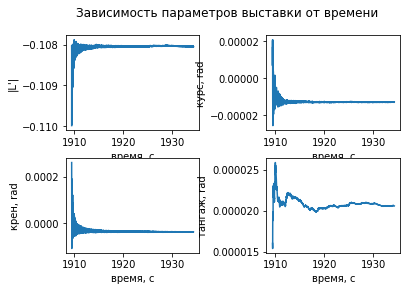

<Figure size 1296x360 with 0 Axes>

In [33]:
fig = plt.figure()
plt.figure(figsize=(18,5));

time = CNF.loc[:239000,['Time']].values
del2 = 10000
fig.suptitle(u"Зависимость параметров выставки от времени")
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(time[50:del2,0], det[50:del2,1])
ax1.set_ylabel(u'|L\'|')
ax1.set_xlabel(u'время, c')

ax2.plot(time[50:del2,0], det[50:del2,4])
ax2.set_ylabel(u'курс, rad')
ax2.set_xlabel(u'время, c')

ax3.plot(time[50:del2,0], det[50:del2,3])
ax3.set_ylabel(u'крен, rad')
ax3.set_xlabel(u'время, c')

ax4.plot(time[50:del2,0], det[50:del2,13])
ax4.set_ylabel(u'тангаж, rad')
ax4.set_xlabel(u'время, c')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

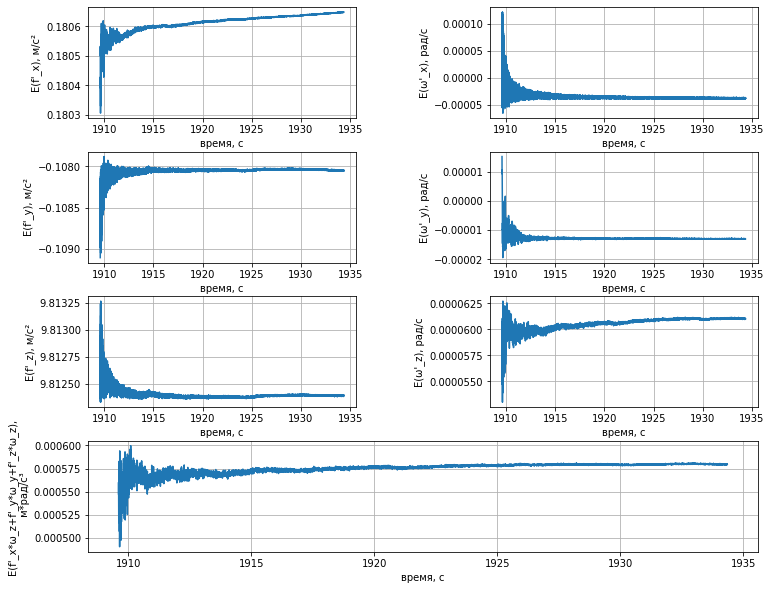

In [35]:
fig = plt.figure(figsize=(12,18))
time = CNF.loc[:239000,['Time']].values
del1 = 100
#plt.figure();
#fig.suptitle(u"Оценки математического ожидания на интервале выставки")
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
ax1 = fig.add_subplot(721)
ax4 = fig.add_subplot(722)
ax2 = fig.add_subplot(723)
ax5 = fig.add_subplot(724)
ax3 = fig.add_subplot(725)
ax6 = fig.add_subplot(726)
ax7 = fig.add_subplot(714)
ax1.plot(time[del1:del2,0], det[del1:del2,0])
#ax1.axis([200, 1000, 97, 98.2])
ax1.grid(b=True, which='major', axis='both')
ax1.set_ylabel(u'E(f\'_x), м/с²')
ax1.set_xlabel(u'время, c')

ax2.plot(time[del1:del2,0], det[del1:del2,1])
#ax2.axis([1000, 1025, 98.005, 98.02])
ax2.grid(b=True, which='major', axis='both')
ax2.set_ylabel(u'E(f\'_y), м/с²')
ax2.set_xlabel(u'время, c')

ax3.plot(time[del1:del2,0], det[del1:del2,2])
#ax3.axis([200, 1000,  -90.002,-89.997])
ax3.grid(b=True, which='major', axis='both')
ax3.set_ylabel(u'E(f\'_z), м/с²')
ax3.set_xlabel(u'время, c')

ax4.plot(time[del1:del2,0], det[del1:del2,3])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax4.grid(b=True, which='major', axis='both')
ax4.set_ylabel(u'E(ω\'_x), рад/с')
ax4.set_xlabel(u'время, c')

ax5.plot(time[del1:del2,0], det[del1:del2,4])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax5.grid(b=True, which='major', axis='both')
ax5.set_ylabel(u'E(ω\'_y), рад/с')
ax5.set_xlabel(u'время, c')

ax6.plot(time[del1:del2,0], det[del1:del2,5])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax6.grid(b=True, which='major', axis='both')
ax6.set_ylabel(u'E(ω\'_z), рад/с')
ax6.set_xlabel(u'время, c')

ax7.plot(time[del1:del2,0], det[del1:del2,6])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax7.grid(b=True, which='major', axis='both')
ax7.set_ylabel(u'E(f\'_x*ω_z+f\'_y*ω_y+f\'_z*ω_z),\n м*рад/с³')
ax7.set_xlabel(u'время, c')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

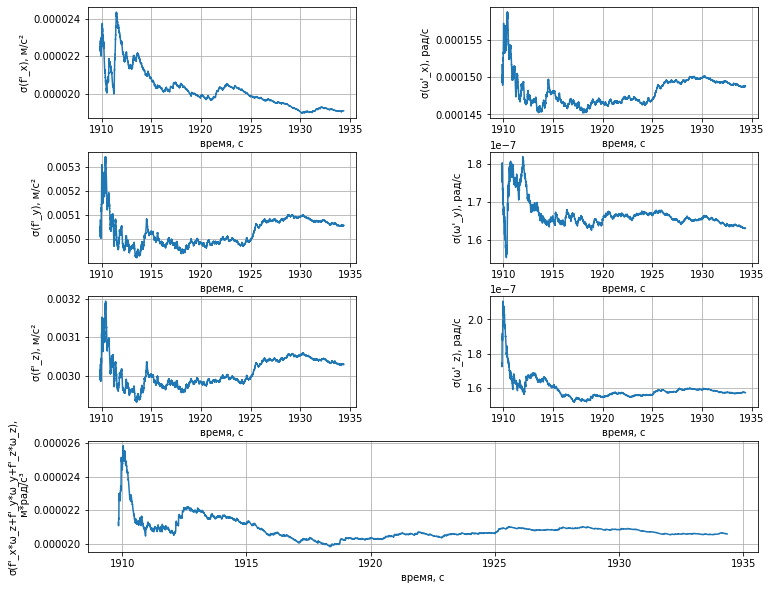

In [36]:
fig = plt.figure(figsize=(12,18))
time = CNF.loc[:239000,['Time']].values
del1 = 200
#plt.figure();
#fig.suptitle(u"Оценки математического ожидания на интервале выставки")
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
ax1 = fig.add_subplot(721)
ax4 = fig.add_subplot(722)
ax2 = fig.add_subplot(723)
ax5 = fig.add_subplot(724)
ax3 = fig.add_subplot(725)
ax6 = fig.add_subplot(726)
ax7 = fig.add_subplot(714)
ax1.plot(time[del1:del2,0], det[del1:del2,7])
#ax1.axis([200, 1000, 97, 98.2])
ax1.grid(b=True, which='major', axis='both')
ax1.set_ylabel(u'σ(f\'_x), м/с²')
ax1.set_xlabel(u'время, c')

ax2.plot(time[del1:del2,0], det[del1:del2,8])
#ax2.axis([1000, 1025, 98.005, 98.02])
ax2.grid(b=True, which='major', axis='both')
ax2.set_ylabel(u'σ(f\'_y), м/с²')
ax2.set_xlabel(u'время, c')

ax3.plot(time[del1:del2,0], det[del1:del2,9])
#ax3.axis([200, 1000,  -90.002,-89.997])
ax3.grid(b=True, which='major', axis='both')
ax3.set_ylabel(u'σ(f\'_z), м/с²')
ax3.set_xlabel(u'время, c')

ax4.plot(time[del1:del2,0], det[del1:del2,10])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax4.grid(b=True, which='major', axis='both')
ax4.set_ylabel(u'σ(ω\'_x), рад/с')
ax4.set_xlabel(u'время, c')

ax5.plot(time[del1:del2,0], det[del1:del2,11])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax5.grid(b=True, which='major', axis='both')
ax5.set_ylabel(u'σ(ω\'_y), рад/с')
ax5.set_xlabel(u'время, c')

ax6.plot(time[del1:del2,0], det[del1:del2,12])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax6.grid(b=True, which='major', axis='both')
ax6.set_ylabel(u'σ(ω\'_z), рад/с')
ax6.set_xlabel(u'время, c')

ax7.plot(time[del1:del2,0], det[del1:del2,13])
#ax4.axis([200, 1000,  -0.0025,0.0025])
ax7.grid(b=True, which='major', axis='both')
ax7.set_ylabel(u'σ(f\'_x*ω_z+f\'_y*ω_y+f\'_z*ω_z),\n м*рад/с³')
ax7.set_xlabel(u'время, c')

plt.show